Trovati 25 test: ['A1_random', 'A2.1_hybrid_sampling', 'A2_balanced_degree', 'A3_corridor_heavy', 'A4_goal_biased', 'A5_wall_band', 'A6_uniform_grid', 'B1_deg_strong', 'B2_goal_strong', 'B3.1_efficient_safety', 'B3_wide_space', 'B4_path_strong', 'B5_gate_strong', 'C1_easy_pairs', 'C2_hard_pairs', 'C3_very_hard_diverse_deg', 'C4_mixed_difficulty', 'D1_small_net', 'D2_dropout_heavy', 'D3_more_epochs', 'E1_fading_density', 'F1_noise_10pct', 'F2_noise_25pct', 'G1_tube_sampling', 'H1_quantized_score']
Creating Path with step 3


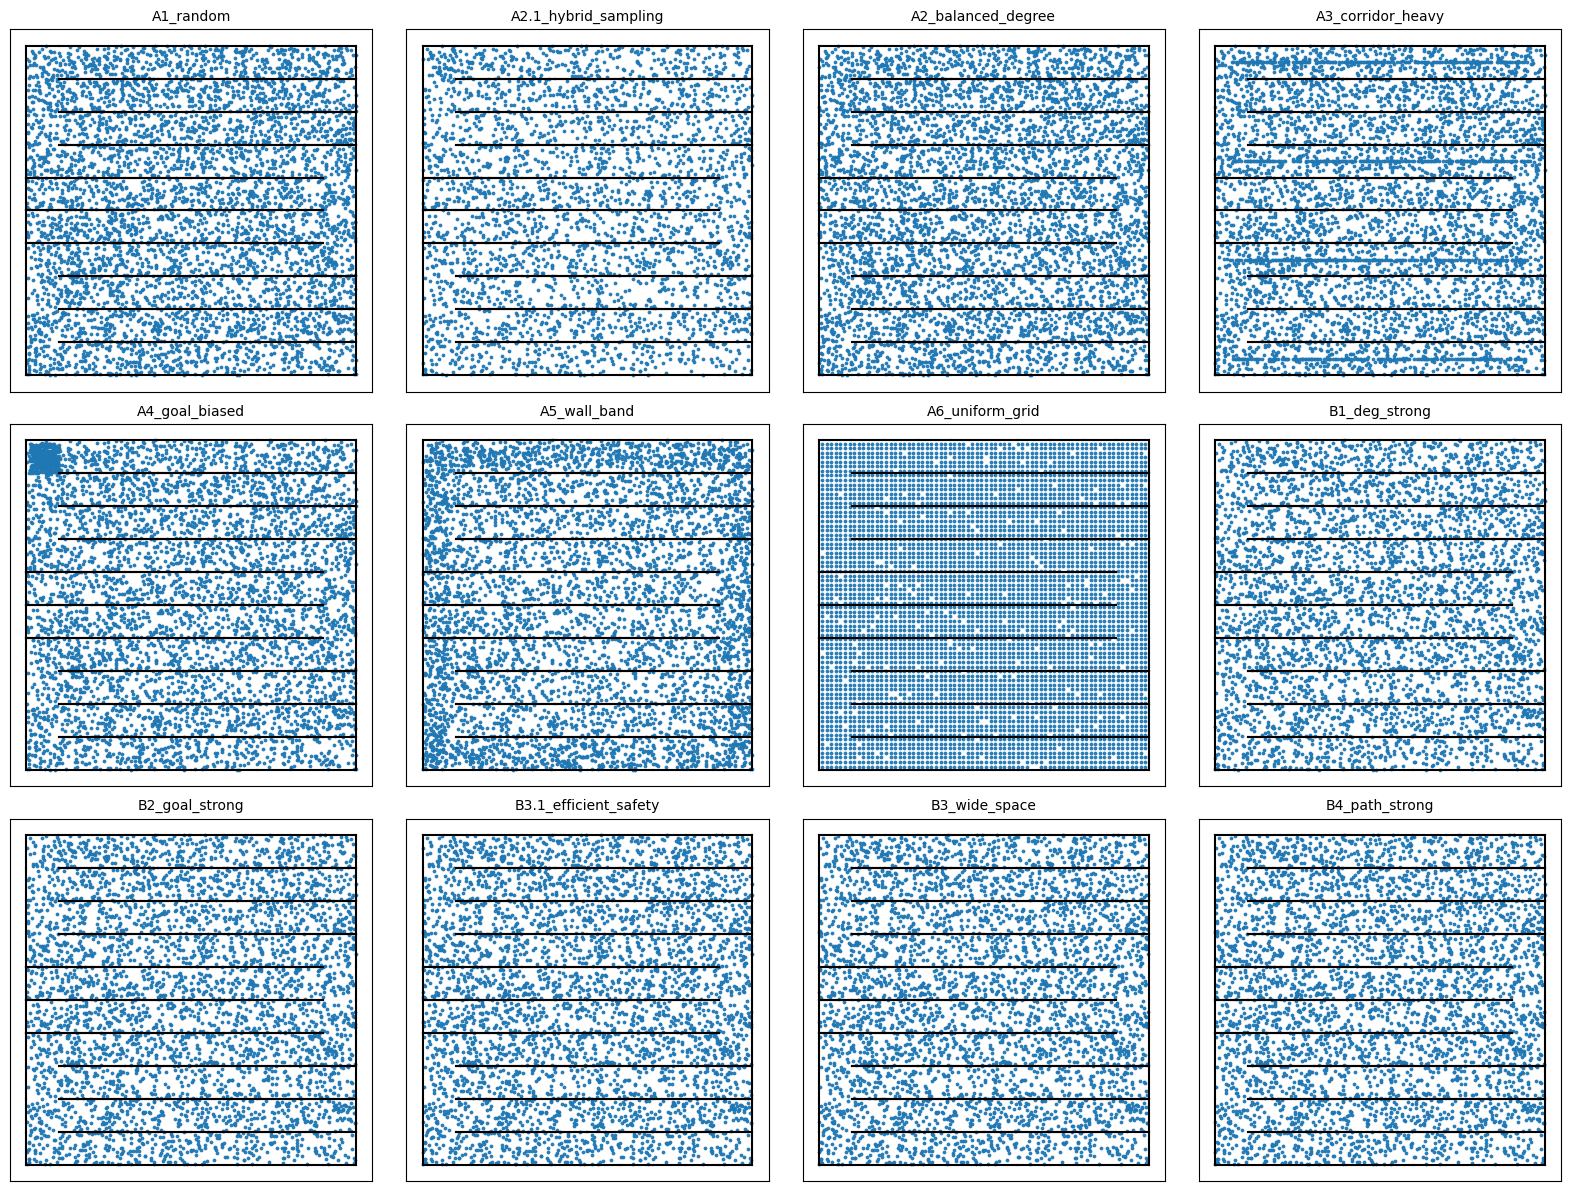

Salvato: /Users/Q540900/Desktop/Direct_Preference_Learning_LLM_Thesis/preferencelearning-main/comparison/outputs/_overview/points_grid_1.png


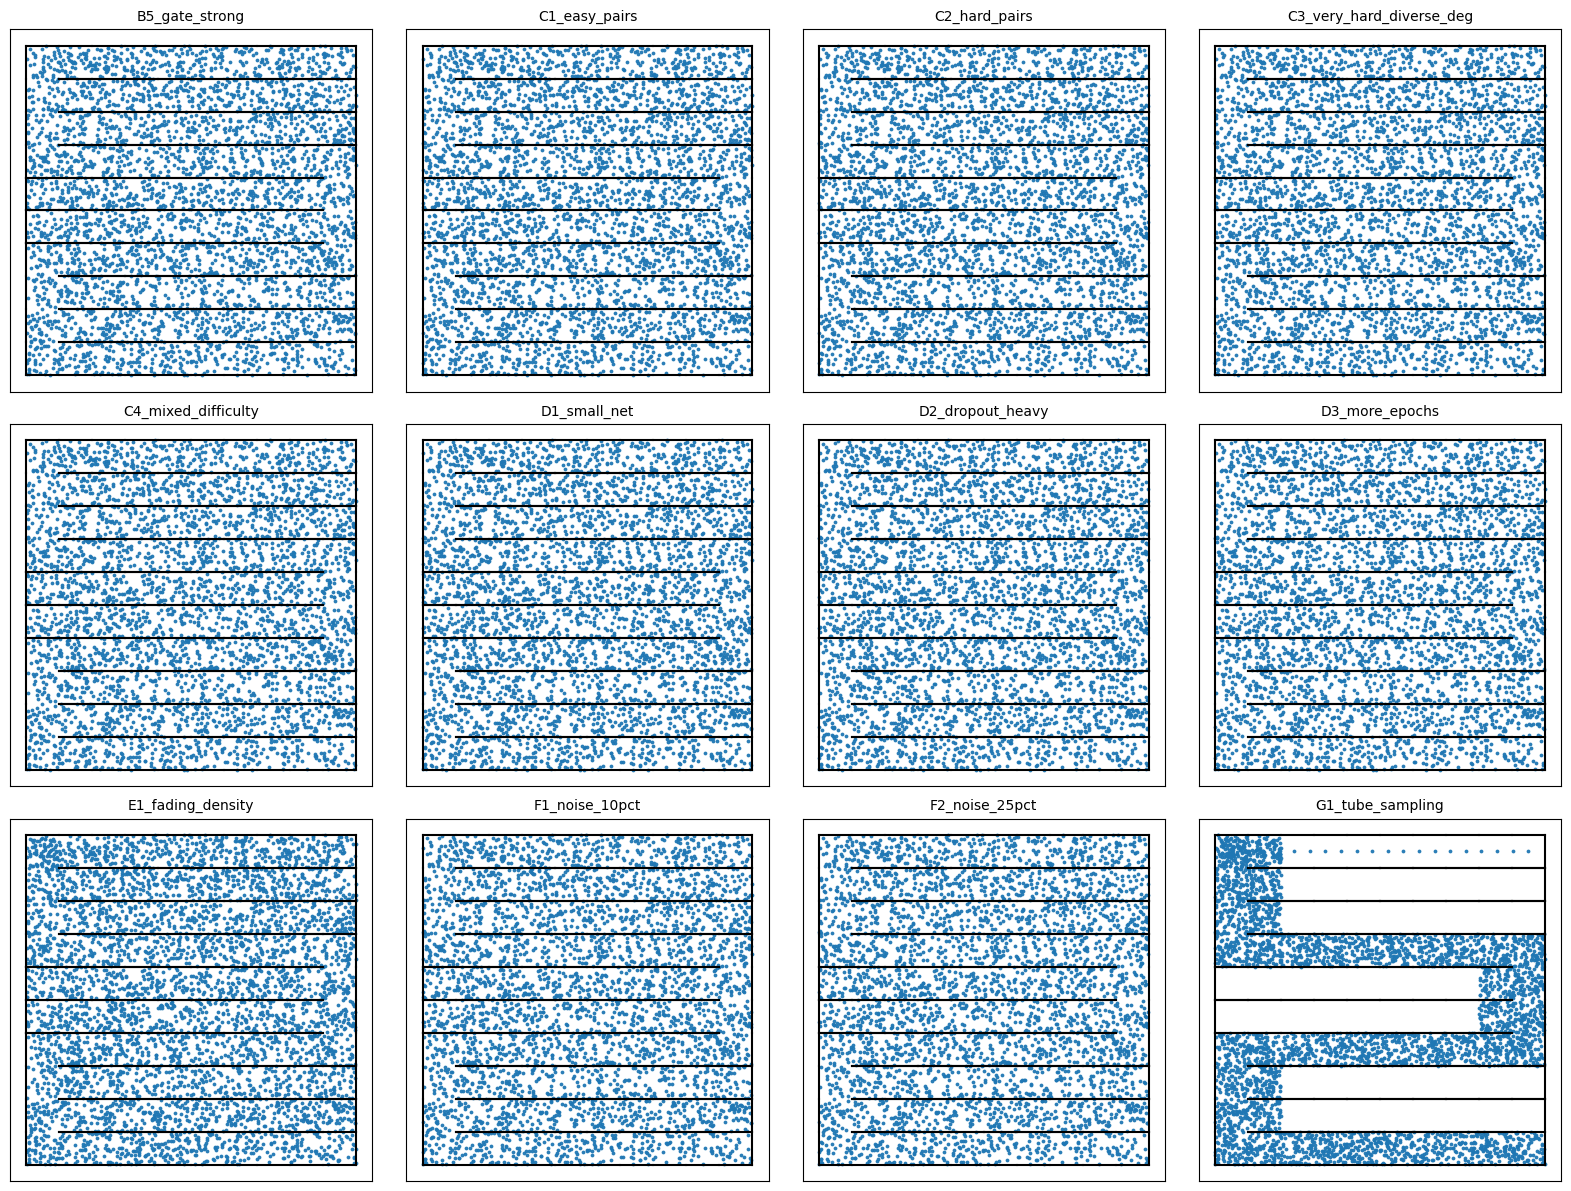

Salvato: /Users/Q540900/Desktop/Direct_Preference_Learning_LLM_Thesis/preferencelearning-main/comparison/outputs/_overview/points_grid_2.png


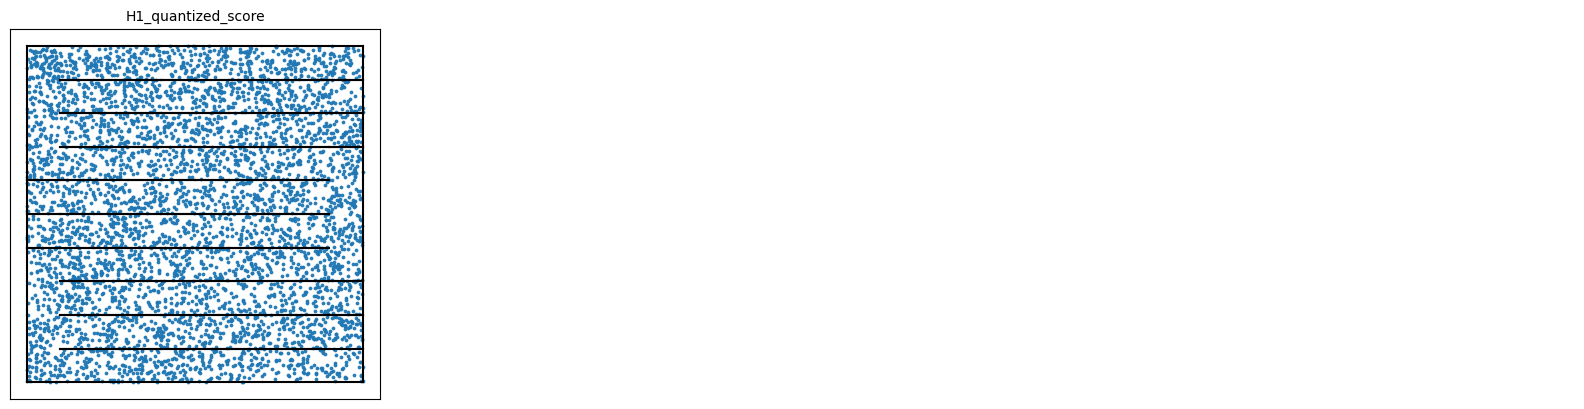

Salvato: /Users/Q540900/Desktop/Direct_Preference_Learning_LLM_Thesis/preferencelearning-main/comparison/outputs/_overview/points_grid_3.png


In [3]:
# --- Maze + Points overview per tutti i test ---
# incolla in una cella di visualization.ipynb
import os, sys, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Imposta i path in base alla posizione del notebook:
# se il notebook è in preferencelearning-main/comparison/, "outputs" è locale.
BASE = Path.cwd()
if BASE.name == "comparison":
    OUTPUTS_DIR = BASE / "outputs"
    SRC_DIR = BASE.parent / "src"
else:
    # fallback: notebook lanciato da root del repo
    OUTPUTS_DIR = BASE / "comparison" / "outputs"
    SRC_DIR = BASE / "src"

assert OUTPUTS_DIR.exists(), f"Cartella output non trovata: {OUTPUTS_DIR}"
assert SRC_DIR.exists(), f"Cartella src non trovata: {SRC_DIR}"

# Importa funzioni dal progetto
sys.path.insert(0, str(SRC_DIR))
from maze import Maze
from maze_env import draw_map  # disegna il labirinto

# --- Parametri di visualizzazione (personalizzabili) ---
N_COLS = 4                    # colonne nella griglia
CHUNK = 12                    # quanti test per figura (pagine da 12 subplots)
MAX_POINTS_PER_TEST = 5000    # sottocampiona per non saturare i plot
COLOR_BY = None               # None oppure nome colonna, es: "total_score" / "degree" / "distance_to_goal"
SCATTER_SIZE = 3
ALPHA = 0.9
SEED = 0

# Rileva tutti i test che hanno positions.parquet
test_dirs = sorted([p for p in OUTPUTS_DIR.iterdir() if (p / "positions.parquet").exists()])
test_names = [p.name for p in test_dirs]
print(f"Trovati {len(test_names)} test:", test_names)

# Crea il Maze "serpentina" (stesso di training/generazione)
maze = Maze(10, 10, 0, 0)
maze.make_maze_fail(step=3)  # serpentina con step=3

rng = np.random.default_rng(SEED)

def plot_chunk(test_paths):
    n = len(test_paths)
    n_cols = N_COLS
    n_rows = math.ceil(n / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    axes = np.array(axes).reshape(n_rows, n_cols)

    for ax, tdir in zip(axes.ravel(), test_paths):
        # Disegna il maze
        draw_map(1/10, maze, ax=ax, alpha=1.0)

        # Carica punti
        df = pd.read_parquet(tdir / "positions.parquet")
        if MAX_POINTS_PER_TEST is not None and len(df) > MAX_POINTS_PER_TEST:
            df = df.sample(MAX_POINTS_PER_TEST, random_state=SEED)

        # Scatter: solo punti o colorati per una metrica
        if COLOR_BY and COLOR_BY in df.columns:
            sc = ax.scatter(df["x"].values, df["y"].values, s=SCATTER_SIZE,
                            c=df[COLOR_BY].values, cmap="viridis", alpha=ALPHA)
            # Colorbar piccola per ogni subplot
            cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
            cb.ax.tick_params(labelsize=8)
        else:
            ax.scatter(df["x"].values, df["y"].values, s=SCATTER_SIZE, alpha=ALPHA)

        ax.set_title(tdir.name, fontsize=10)
        ax.set_aspect("equal")
        ax.invert_xaxis()
        ax.set_xticks([]); ax.set_yticks([])

    # Nasconde eventuali assi in eccesso
    for ax in axes.ravel()[n:]:
        ax.axis("off")

    plt.tight_layout()
    return fig

# Genera figure in "pagine"
overview_dir = OUTPUTS_DIR / "_overview"
overview_dir.mkdir(exist_ok=True)

for i in range(0, len(test_dirs), CHUNK):
    batch = test_dirs[i:i+CHUNK]
    fig = plot_chunk(batch)
    out_path = overview_dir / f"points_grid_{i//CHUNK + 1}.png"
    fig.savefig(out_path, dpi=150)
    plt.show()
    print(f"Salvato: {out_path}")


In [3]:
# # Diagnostica mismatch: policy_legal vs step_collision
# import sys, os, numpy as np
# from pathlib import Path

# BASE = Path.cwd()
# SRC = BASE / "src" if (BASE / "src").is_dir() else BASE.parent / "src"
# sys.path.insert(0, str(SRC))

# from maze import Maze
# from maze_env import MazeEnv

# def candidate_actions(env):
#     angles = np.linspace(-1, 1, 32, endpoint=False, dtype=np.float32)
#     fine = [0.002, 0.005, 0.008]
#     speeds = fine + [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]
#     cell = 1.0 / env.sz
#     speeds = [0.5*cell/env.dt, 0.8*cell/env.dt, cell/env.dt] + speeds
#     a, s = np.meshgrid(angles, speeds)
#     return np.stack([s.ravel(), a.ravel()], axis=1)

# def is_legal_policy(env, s_from, s_to, n=4):
#     # quello che usavamo nel rollout: campionamento + segment_collision (strict=True)
#     alphas = np.linspace(0., 1., n)
#     for a in alphas:
#         p = (1-a)*s_from + a*s_to
#         if env.point_collision(p[0], p[1]):
#             return False
#     return not env.segment_collision(s_from, s_to)  # strict=True dentro la definizione

# def step_would_collide(env, s_to):
#     # esattamente ciò che fa step() per la collisione del segmento start->s_to
#     return env.collision(s_to)

# # -- setup env baseline
# maze = Maze(10,10,0,0)
# env  = MazeEnv(sz=10, maze=maze, start=np.array([0.05,0.05]),
#                goal=np.array([0.95,0.95]), reward="distance",
#                dt=0.15, horizon=180, slide=1, use_dpo=False)

# acts = candidate_actions(env)

# for t in range(20):  # pochi step di diagnostica
#     next_states = env.state + np.stack(
#         [acts[:,0]*np.cos(acts[:,1]*np.pi)*env.dt,
#          acts[:,0]*np.sin(acts[:,1]*np.pi)*env.dt], axis=1)

#     pol_legal = []
#     step_ok   = []
#     mismatch  = []
#     for i, s1 in enumerate(next_states):
#         Lp = is_legal_policy(env, env.state, s1)
#         Ls = not step_would_collide(env, s1)
#         pol_legal.append(Lp)
#         step_ok.append(Ls)
#         mismatch.append(Lp and (not Ls))

#     print(f"step {t:02d} | policy_legal={np.sum(pol_legal)} | step_ok={np.sum(step_ok)} | mismatch={np.sum(mismatch)} | dist={np.linalg.norm(env.goal-env.state):.3f}")

#     # muovi con una mossa sicura secondo LO STESSO criterio dello step (per avanzare)
#     idxs_ok = np.where(np.array(step_ok))[0]
#     if len(idxs_ok)==0:
#         # resta fermo (diagnostica)
#         pass
#     else:
#         # prendi fra quelle ok quella che più riduce la distanza
#         dists = np.linalg.norm(env.goal - next_states[idxs_ok], axis=1)
#         a = acts[idxs_ok[np.argmin(dists)]]
#         new_pose = env.state + a[0]*env.dt*np.array([np.cos(a[1]*np.pi), np.sin(a[1]*np.pi)])
#         env.step(a, epsilon_goal=0.106)
#     if np.linalg.norm(env.goal - env.state) < 0.106:
#         print("✅ goal raggiunto durante la diagnostica")
#         break


In [4]:
# # Diagnostica: quante azioni legali riducono (a) distanza euclidea e (b) distanza di percorso (BFS)?
# import sys, os, numpy as np
# from pathlib import Path
# from collections import deque

# BASE = Path.cwd()
# SRC = BASE / "src" if (BASE / "src").is_dir() else BASE.parent / "src"
# sys.path.insert(0, str(SRC))

# from maze import Maze
# from maze_env import MazeEnv

# def candidate_actions(env):
#     angles = np.linspace(-1, 1, 32, endpoint=False, dtype=np.float32)
#     fine = [0.002, 0.005, 0.008]
#     speeds = fine + [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]
#     cell = 1.0 / env.sz
#     speeds = [0.5*cell/env.dt, 0.8*cell/env.dt, cell/env.dt] + speeds
#     a, s = np.meshgrid(angles, speeds)
#     return np.stack([s.ravel(), a.ravel()], axis=1)

# def can_move(env, cx, cy, nx, ny):
#     if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
#         return False
#     if all(env.maze.cell_at(nx, ny).walls.values()):
#         return False
#     c  = env.maze.cell_at(cx, cy)
#     n  = env.maze.cell_at(nx, ny)
#     dx, dy = nx - cx, ny - cy
#     if   dx==0 and dy==-1 and (c.walls["N"] or n.walls["S"]): return False
#     elif dx==0 and dy== 1 and (c.walls["S"] or n.walls["N"]): return False
#     elif dx== 1 and dy==0  and (c.walls["E"] or n.walls["W"]): return False
#     elif dx==-1 and dy==0  and (c.walls["W"] or n.walls["E"]): return False
#     return True

# def shortest_path_cells(env, s):
#     cx, cy = min(int(s[0]*env.sz), env.maze.nx-1), min(int(s[1]*env.sz), env.maze.ny-1)
#     gx, gy = min(int(env.goal[0]*env.sz), env.maze.nx-1), min(int(env.goal[1]*env.sz), env.maze.ny-1)
#     dist = { (cx,cy): 0 }
#     Q = deque([(cx,cy)])
#     while Q:
#         ux, uy = Q.popleft()
#         if (ux,uy) == (gx,gy): break
#         for dx,dy in [(-1,0),(1,0),(0,-1),(0,1)]:
#             vx, vy = ux+dx, uy+dy
#             if not can_move(env, ux, uy, vx, vy): continue
#             if (vx,vy) not in dist:
#                 dist[(vx,vy)] = dist[(ux,uy)] + 1
#                 Q.append((vx,vy))
#     return dist.get((gx,gy), np.inf)

# # Setup
# maze = Maze(10,10,0,0)
# env  = MazeEnv(sz=10, maze=maze, start=np.array([0.05,0.05]),
#                goal=np.array([0.95,0.95]), reward="distance",
#                dt=0.15, horizon=180, slide=1, use_dpo=False)
# acts = candidate_actions(env)

# for t in range(20):
#     next_states = env.state + np.stack(
#         [acts[:,0]*np.cos(acts[:,1]*np.pi)*env.dt,
#          acts[:,0]*np.sin(acts[:,1]*np.pi)*env.dt], axis=1)

#     # legali secondo lo step (segmento non collide)
#     idxs_ok = [i for i in range(len(acts)) if not env.collision(next_states[i])]

#     d0 = float(np.linalg.norm(env.goal - env.state))
#     p0 = shortest_path_cells(env, env.state)

#     dists = np.linalg.norm(env.goal - next_states[idxs_ok], axis=1)
#     paths = np.array([shortest_path_cells(env, s) for s in next_states[idxs_ok]])

#     eu_improve   = np.sum(dists < d0 - 1e-6)
#     path_improve = np.sum(paths < p0 - 1e-9)

#     print(f"step {t:02d} | legal={len(idxs_ok)} | eu_improve={eu_improve} | path_improve={path_improve} | dist={d0:.3f} | path={p0}")

#     # muovi con criterio dello step per proseguire
#     if len(idxs_ok)==0:
#         break
#     # prova prima euclidea; se none, scegli min path
#     if eu_improve > 0:
#         i = idxs_ok[np.argmin(dists)]
#     else:
#         i = idxs_ok[np.argmin(paths)]
#     a = acts[i]
#     env.step(a, epsilon_goal=0.106)
#     if np.linalg.norm(env.goal - env.state) < 0.106:
#         print("✅ goal raggiunto (diagnostica)")
#         break


DPO wins: 5 | ties: 3 | losses: 10 | avg Δsteps (baseline−DPO): -1.67


,test_id,n_points,n_pairs,best_val,test_accuracy,dpo_steps,baseline_steps,delta_steps
0,A1_random,6000,200000,0.026504,0.964100,28.0,29,1.0
1,A2.1_hybrid_sampling,3060,200000,0.028398,0.956500,35.0,29,-6.0
2,A2_balanced_degree,6040,200000,0.028078,0.958400,33.0,29,-4.0
3,A3_corridor_heavy,6800,200000,0.023446,0.969100,28.0,29,1.0
4,A4_goal_biased,6440,200000,0.027870,0.962100,29.0,29,0.0
5,A5_wall_band,7540,200000,0.026390,0.962600,29.0,29,0.0
6,A6_uniform_grid,5184,200000,0.021175,0.970700,31.0,29,-2.0
7,B1_deg_strong,4080,200000,0.039795,0.936500,30.0,29,-1.0
8,B2_goal_strong,4080,200000,0.022856,0.969100,NaN,29,NaN
9,B3.1_efficient_safety,4080,200000,0.094807,0.849800,NaN,29,NaN


✓ Salvato CSV: /Users/Q540900/Desktop/Direct_Preference_Learning_LLM_Thesis/preferencelearning-main/comparison/outputs/_metrics_summary.csv


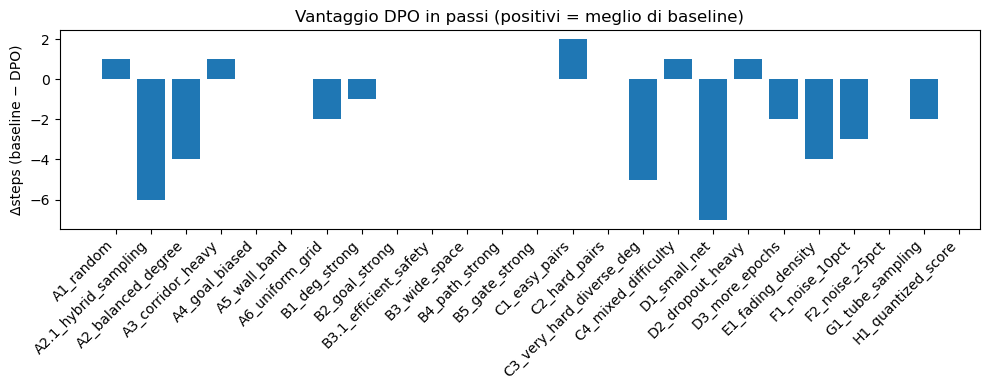

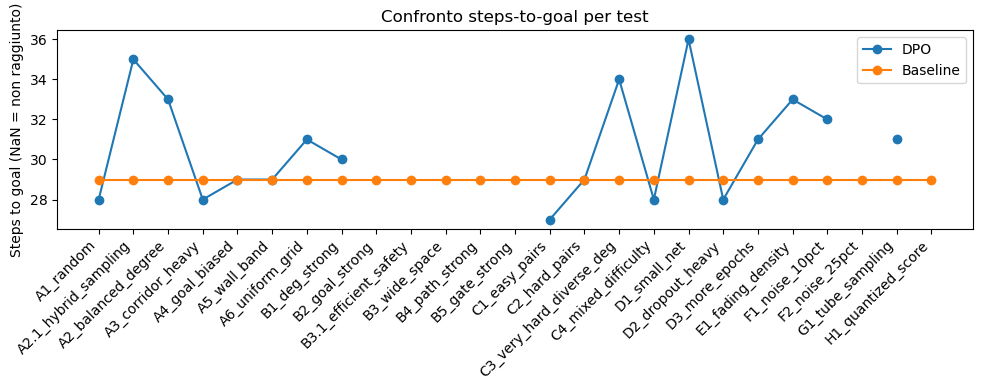

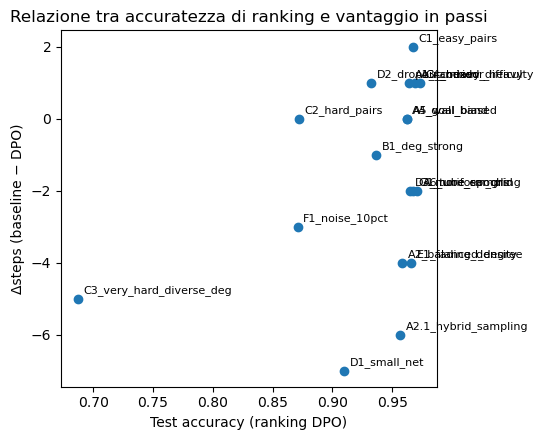

In [4]:
# ## Confronto numerico dai report.json
# - Aggrega metriche
# - Calcola delta_steps = baseline - dpo
# - Mostra tabella e tre grafici separati
import os, sys, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

warnings.filterwarnings("ignore", category=UserWarning)

def find_outputs_dir():
    candidates = [
        Path.cwd() / "outputs",
        Path.cwd() / "comparison" / "outputs",
        Path.cwd().parent / "comparison" / "outputs",
        Path.cwd().parent.parent / "comparison" / "outputs",
    ]
    for p in candidates:
        if p.is_dir():
            return p.resolve()
    raise FileNotFoundError("Non trovo 'comparison/outputs'. Apri il notebook dentro 'comparison/' o aggiorna i path.")

OUTPUTS_DIR = find_outputs_dir()

# --- carica report.json di tutti i test ---
records = []
for tdir in sorted(OUTPUTS_DIR.iterdir()):
    if not tdir.is_dir(): 
        continue
    rpath = tdir / "report.json"
    if not rpath.exists():
        continue
    with open(rpath, "r") as f:
        rep = json.load(f)

    # safe cast: -1 -> NaN (non raggiunto)
    def ok_steps(x):
        try:
            v = int(x)
            return np.nan if v < 0 else v
        except Exception:
            return np.nan

    rec = {
        "test_id": rep.get("test_id", tdir.name),
        "n_points": rep.get("n_points", np.nan),
        "n_pairs": rep.get("n_pairs", np.nan),
        "best_val": rep.get("training", {}).get("best_val", np.nan),
        "test_accuracy": rep.get("training", {}).get("test_accuracy", np.nan),
        "dpo_steps": ok_steps(rep.get("solve", {}).get("dpo_steps_to_goal", np.nan)),
        "baseline_steps": ok_steps(rep.get("solve", {}).get("baseline_steps_to_goal", np.nan)),
    }
    # delta positivo = DPO meglio (meno passi)
    if np.isnan(rec["dpo_steps"]) or np.isnan(rec["baseline_steps"]):
        rec["delta_steps"] = np.nan
    else:
        rec["delta_steps"] = rec["baseline_steps"] - rec["dpo_steps"]

    records.append(rec)

df = pd.DataFrame(records).sort_values("test_id").reset_index(drop=True)

# --- sintesi globale ---
wins = int((df["delta_steps"] > 0).sum())
ties = int((df["delta_steps"] == 0).sum())
loss = int((df["delta_steps"] < 0).sum())
avg_impr = float(df["delta_steps"].dropna().mean()) if df["delta_steps"].notna().any() else np.nan
print(f"DPO wins: {wins} | ties: {ties} | losses: {loss} | avg Δsteps (baseline−DPO): {avg_impr:.2f}")

# --- tabella interattiva + CSV
try:
    import ace_tools
    ace_tools.display_dataframe_to_user("Confronto numerico per test", df)
except Exception:
    display(df)

summary_csv = OUTPUTS_DIR / "_metrics_summary.csv"
df.to_csv(summary_csv, index=False)
print(f"✓ Salvato CSV: {summary_csv}")

# --- GRAFICO 1: Δsteps (baseline - DPO) per test
plt.figure(figsize=(max(6, 0.4*len(df)), 4))
plt.bar(df["test_id"], df["delta_steps"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Δsteps (baseline − DPO)")
plt.title("Vantaggio DPO in passi (positivi = meglio di baseline)")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "_delta_steps.png", dpi=150)
plt.show()

# --- GRAFICO 2: Steps to goal per test (DPO vs Baseline)
plt.figure(figsize=(max(6, 0.4*len(df)), 4))
plt.plot(df["test_id"], df["dpo_steps"], marker="o", label="DPO")
plt.plot(df["test_id"], df["baseline_steps"], marker="o", label="Baseline")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Steps to goal (NaN = non raggiunto)")
plt.title("Confronto steps-to-goal per test")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "_steps_comparison.png", dpi=150)
plt.show()

# --- GRAFICO 3: test_accuracy vs Δsteps
plt.figure(figsize=(5.5, 4.5))
plt.scatter(df["test_accuracy"], df["delta_steps"])
for i, row in df.iterrows():
    plt.annotate(row["test_id"], (row["test_accuracy"], row["delta_steps"]), fontsize=8, xytext=(4,4), textcoords="offset points")
plt.xlabel("Test accuracy (ranking DPO)")
plt.ylabel("Δsteps (baseline − DPO)")
plt.title("Relazione tra accuratezza di ranking e vantaggio in passi")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "_acc_vs_delta.png", dpi=150)
plt.show()


Test: A3_corridor_heavy
DPO steps: 28
Baseline steps: 29
Creating Path with step 3
Creating Path with step 3
Step called. Counter: 0, Horizon: 240
Step called. Counter: 1, Horizon: 240
Step called. Counter: 2, Horizon: 240
Step called. Counter: 3, Horizon: 240
Step called. Counter: 4, Horizon: 240
Step called. Counter: 5, Horizon: 240
Step called. Counter: 6, Horizon: 240
Step called. Counter: 7, Horizon: 240
Step called. Counter: 8, Horizon: 240
Step called. Counter: 9, Horizon: 240
Step called. Counter: 10, Horizon: 240
Step called. Counter: 11, Horizon: 240
Step called. Counter: 12, Horizon: 240
Step called. Counter: 13, Horizon: 240
Step called. Counter: 14, Horizon: 240
Step called. Counter: 15, Horizon: 240
Step called. Counter: 16, Horizon: 240
Step called. Counter: 17, Horizon: 240
Step called. Counter: 18, Horizon: 240
Step called. Counter: 19, Horizon: 240
Step called. Counter: 20, Horizon: 240
Step called. Counter: 21, Horizon: 240
Step called. Counter: 22, Horizon: 240
Step

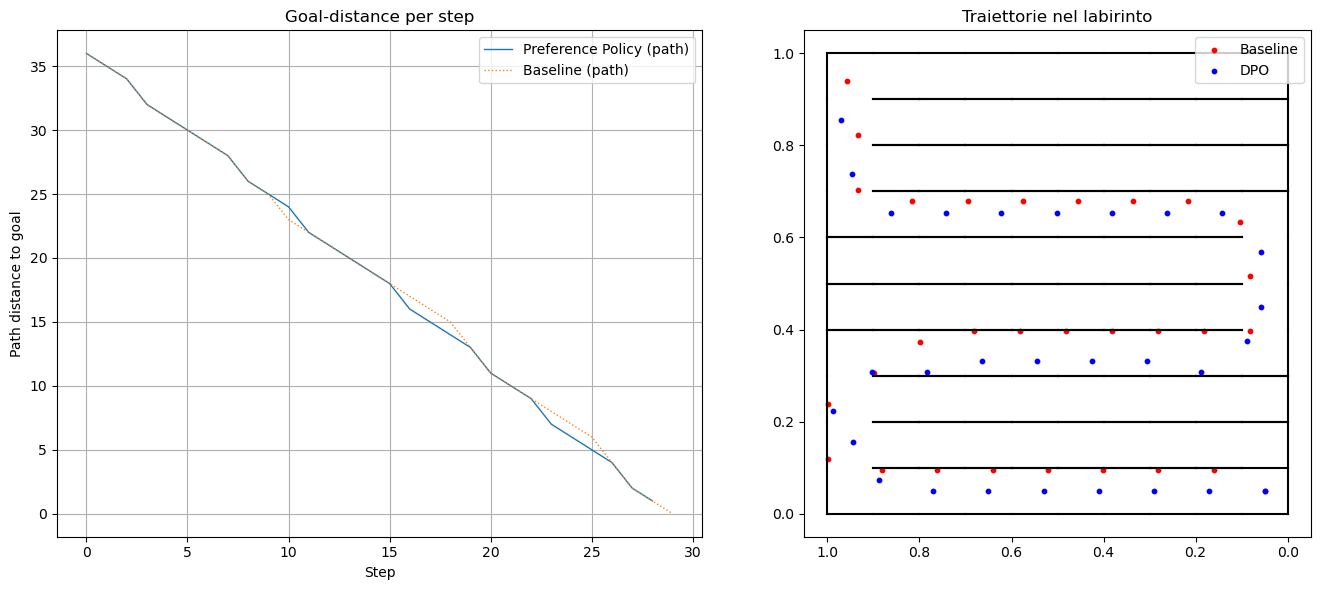

In [9]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import os
import sys
import math
import time
import json
import random
from dataclasses import dataclass, asdict
from typing import Callable, Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# SciPy: usata solo per la euristica euclidea in A*
try:
    from scipy.spatial import distance as scipy_distance
except Exception:
    scipy_distance = None  # fallback

SRC_DIR  = '../src'
assert os.path.isdir(SRC_DIR), f"src non trovato in {SRC_DIR}"
sys.path.insert(0, SRC_DIR)

from maze_env import MazeEnv, draw_map
from maze import Maze

# ---------------------------------------------------------
# Seleziona test da visualizzare
# ---------------------------------------------------------
test_id = "A3_corridor_heavy"
root = "outputs"
test_dir = os.path.join(root, test_id)

# Carica report.json
with open(os.path.join(test_dir, "report.json"), "r") as f:
    report = json.load(f)

print("Test:", report["test_id"])
print("DPO steps:", report["solve"]["dpo_steps_to_goal"])
print("Baseline steps:", report["solve"]["baseline_steps_to_goal"])

# ---------------------------------------------------------
# Ricostruisci lo stesso ambiente usato nei rollouts
# ---------------------------------------------------------
maze = Maze(10, 10, 0, 0)
env_base = MazeEnv(
    sz=10, maze=maze,
    start=np.array([0.05,0.05]),
    goal=np.array([0.95,0.95]),
    use_dpo=False,
    dt=0.15, horizon=240
)

env_dpo = MazeEnv(
    sz=10, maze=maze,
    start=np.array([0.05,0.05]),
    goal=np.array([0.95,0.95]),
    use_dpo=True,
    dpo_model_path=os.path.join(test_dir, "best_dpo_policy.pth"),
    hidden_dim=256, num_layers=4, dropout_prob=0.05,
    dt=0.15, horizon=240
)

# Ricarica le statistiche di normalizzazione
stats = np.load("../tests/norm_stats.npz")
env_dpo._mean = torch.tensor(stats["mean"], dtype=torch.float32, device=env_dpo.device)
env_dpo._std  = torch.tensor(stats["std"] + 1e-8, dtype=torch.float32, device=env_dpo.device)

# ---------------------------------------------------------
# Funzioni di rollout (copiate dalla pipeline)
# ---------------------------------------------------------
from comparison import _policy_baseline_lexico, _policy_dpo_two_step_safe, _rollout

device = env_dpo.device


# DPO
# MODIFICA QUI: passiamo epsilon_goal alla policy
traj_dpo, dist_dpo, iter_dpo, path_dpo = _rollout(
    env_dpo, 
    lambda e: _policy_dpo_two_step_safe(e, device=device, epsilon_goal=0.106),
    max_steps=240, 
    epsilon_goal=0.12
)

traj_base, dist_base, iter_base, path_base = _rollout(
    env_base, _policy_baseline_lexico,
    max_steps=240, epsilon_goal=0.12
)

# ---------------------------------------------------------
# Visualizzazione
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# --- (1) distanza per step ---
axes[0].plot(path_dpo, label="Preference Policy (path)", lw=1)
axes[0].plot(path_base, label="Baseline (path)", lw=1, ls=":")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Path distance to goal")
axes[0].set_title("Goal-distance per step")
axes[0].grid(True)
axes[0].legend()

# --- (2) Mappa + traiettorie ---
draw_map(1/env_dpo.sz, env_dpo.maze, ax=axes[1], alpha=1.0)
axes[1].scatter(traj_base[:,0], traj_base[:,1], s=10, label="Baseline", color="red")
axes[1].scatter(traj_dpo[:,0],  traj_dpo[:,1],  s=10, label="DPO",      color="blue")

axes[1].invert_xaxis()
axes[1].set_aspect("equal")
axes[1].set_title("Traiettorie nel labirinto")
axes[1].legend()

plt.tight_layout()
plt.show()
